# Human PBMCs from 10X data 

Here we analyse the 10k PBMCs from a healthy donor (v3 chemistry) (Cell Ranger 3.0.0).
Link to the dataset: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb


import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/pbmc10x_10kv3.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [4]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [42]:
# Set up data loading
file_base = '../../Munich/datasets/human/10xPBMC/filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )

... reading from cache file cache/..-..-Munich-datasets-human-10xPBMC-filtered_feature_bc_matrix-matrix.h5ad


In [43]:
adata

View of AnnData object with n_obs × n_vars = 11769 × 33538 
    var: 'gene_ids', 'feature_types'

In [7]:
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [44]:
adata.X = adata.X.toarray()

In [45]:
adata.var_names_make_unique()

In [46]:
# Checking the total size of the data set
adata.shape

(11769, 33538)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [47]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [48]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


... storing 'feature_types' as categorical


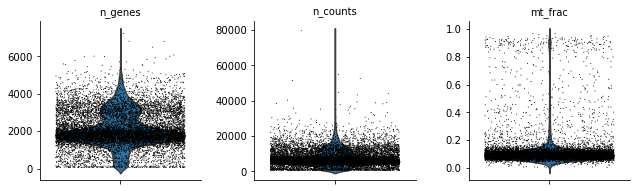

In [49]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

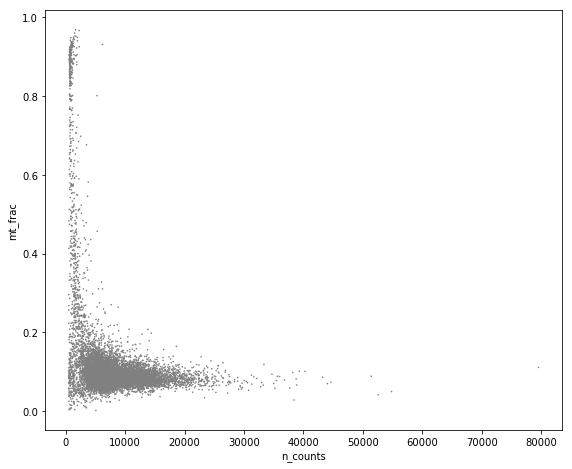

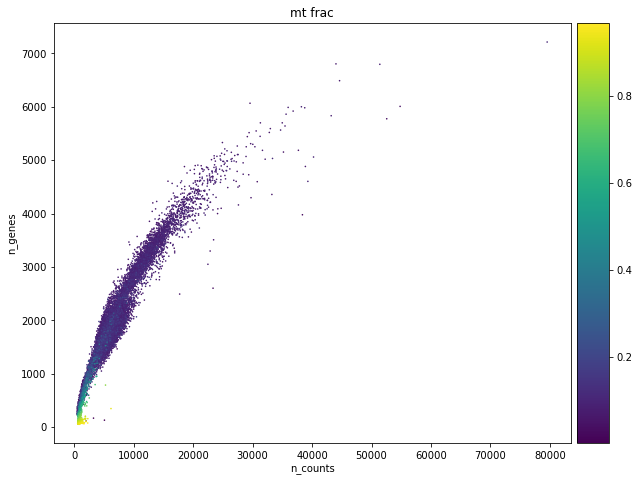

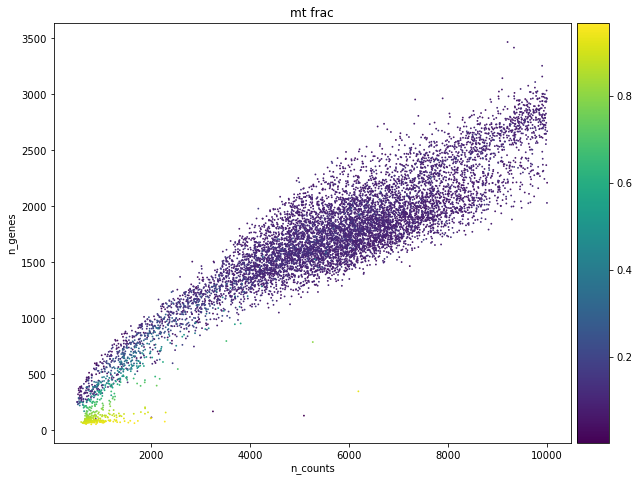

In [50]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='mt_frac')

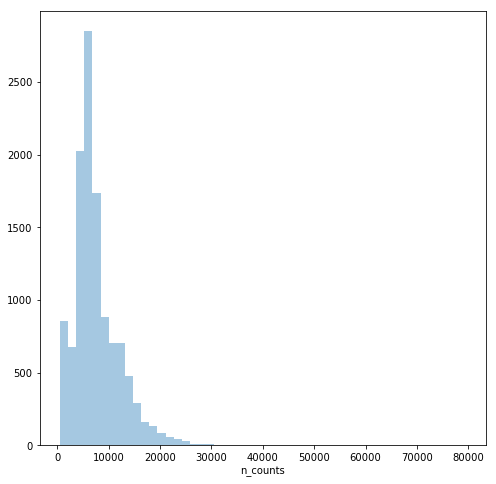

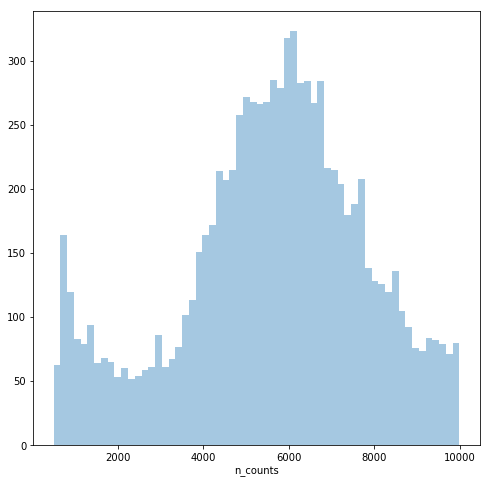

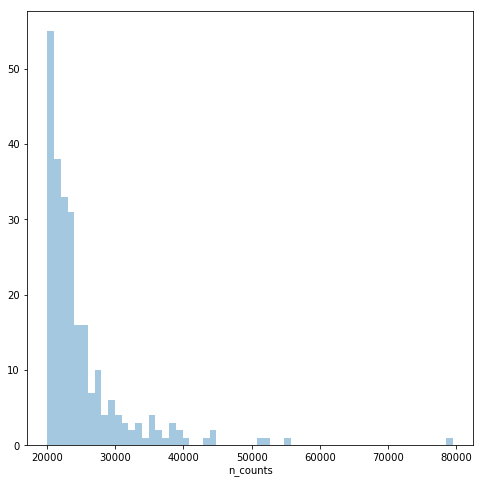

In [52]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

Zoom-in histograms of the number of counts per cell show that there's a smaller group of cells with n_counts < 2000 which are likely uninformative. On the upper end of the distribution, we can see that the high peak centered around 20000 counts spans until around 40000 counts.

In [53]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 11769
filtered out 825 cells that haveless than 2000 counts
Number of cells after min count filter: 10944
filtered out 8 cells that havemore than 40000 counts
Number of cells after max count filter: 10936
Number of cells after MT filter: 10743


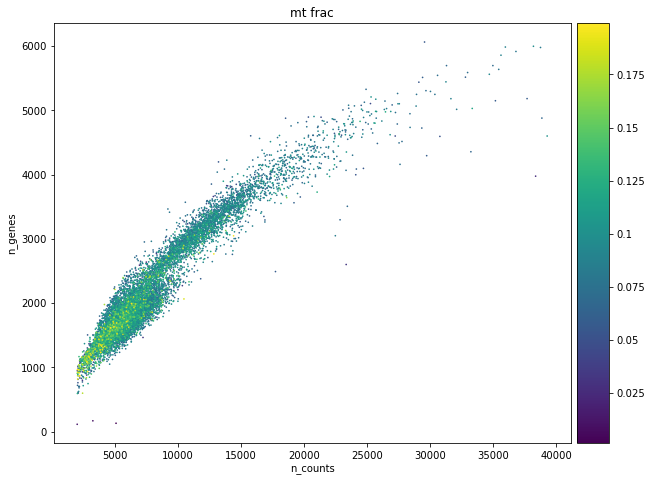

In [54]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

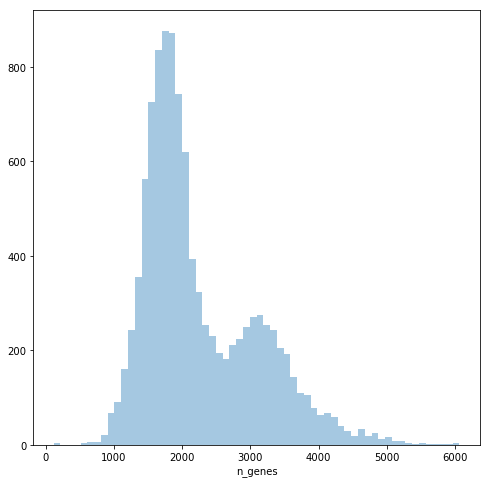

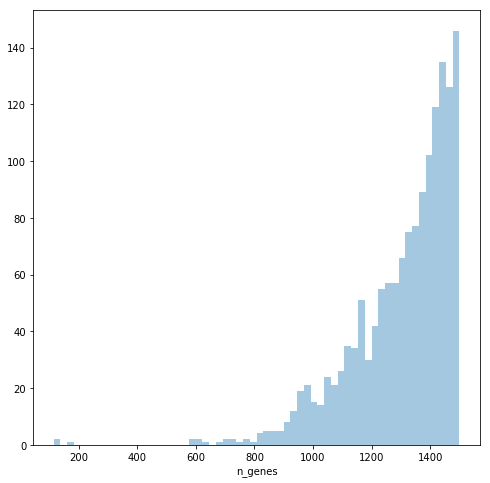

In [55]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 800 which should be filtered out.

In [56]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 800)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 10743
filtered out 16 cells that haveless than 800 genes expressed
Number of cells after gene filter: 10727


In [57]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 17704 genes that are detectedin less than 20 cells
Number of genes after cell filter: 15834


## 1.2 Normalization

In [58]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [59]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     1822
1     1497
2     1447
3     1435
4     1044
5      900
6      787
7      555
8      343
9      331
10     328
11     137
12      80
13      21
Name: groups, dtype: int64

In [60]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [61]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [62]:
#Delete adata_pp
del adata_pp

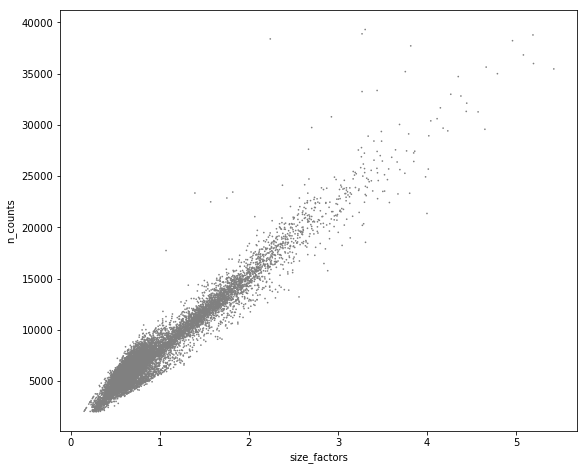

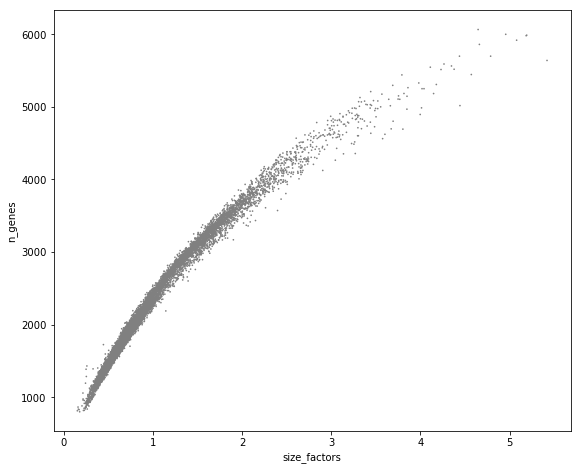

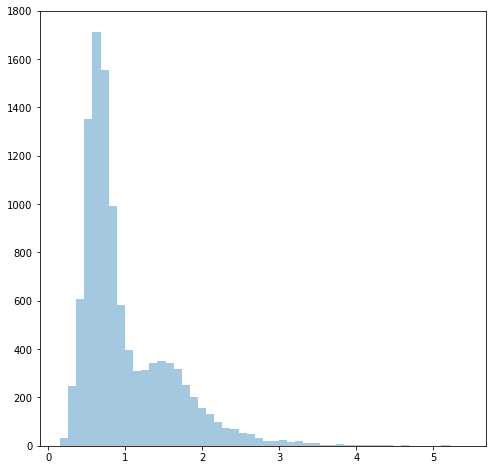

In [63]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [64]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [65]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [66]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [67]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


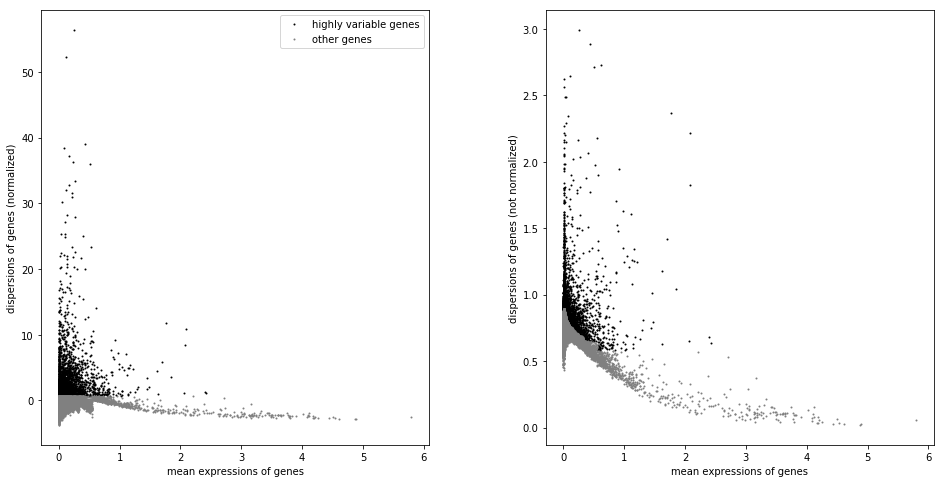

In [68]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [69]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9998162  0.99958766 0.9977485  0.99740446 0.99330044
     0.9919277  0.9912344  0.9897092  0.9869895  0.9854423  0.98390096
     0.9814023  0.9801821  0.9706549 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:09)


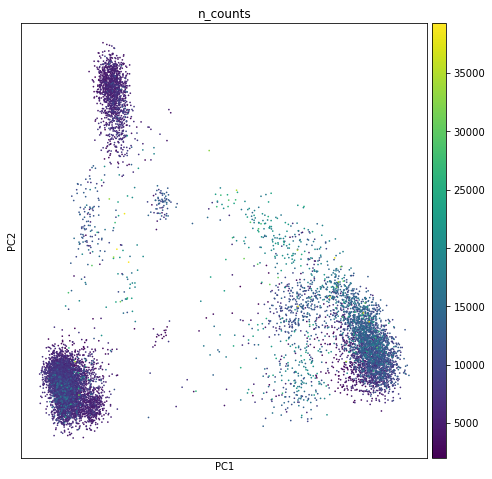

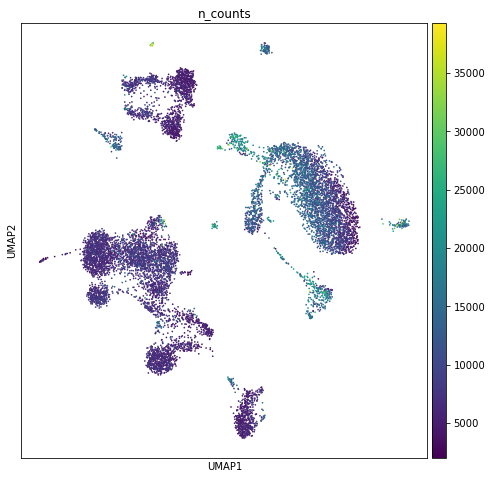

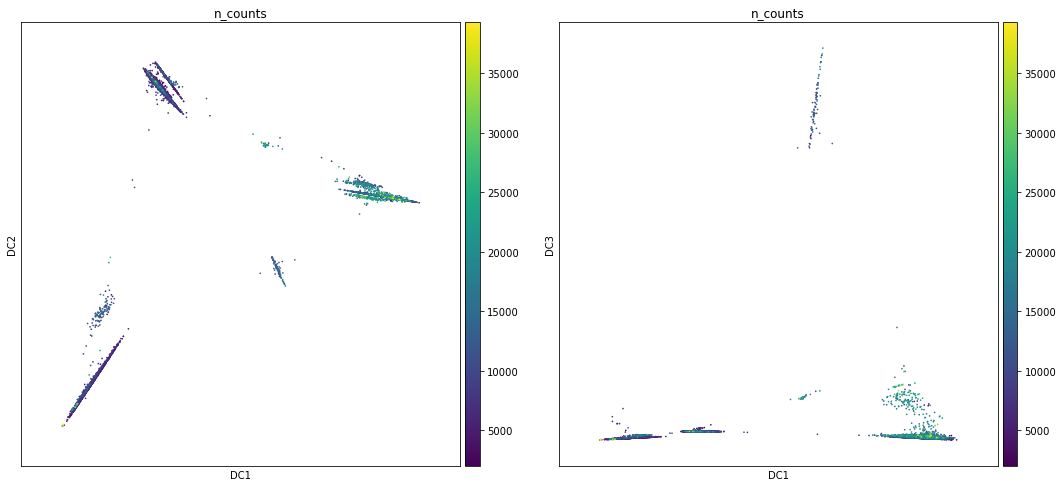

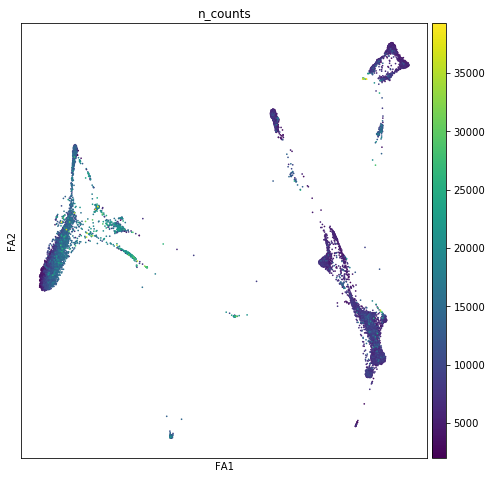

In [70]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [71]:
adata.write(results_file)

# 3. Clustering

In [72]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


In [73]:
adata.obs['louvain_r1'].value_counts()

0     1780
1     1541
2     1227
3     1157
4      794
5      601
6      600
7      552
8      417
9      364
10     350
11     300
12     293
13     246
14     182
15     119
16      81
17      74
18      28
19      21
Name: louvain_r1, dtype: int64

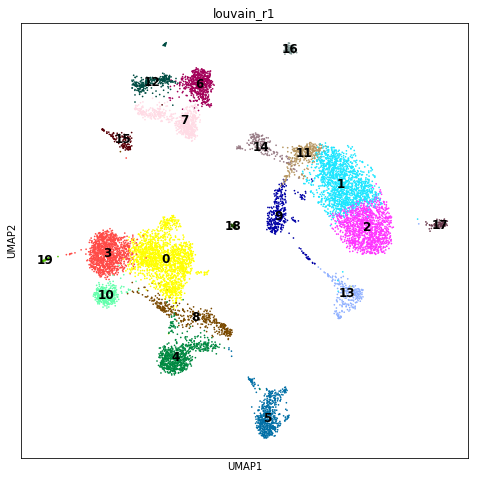

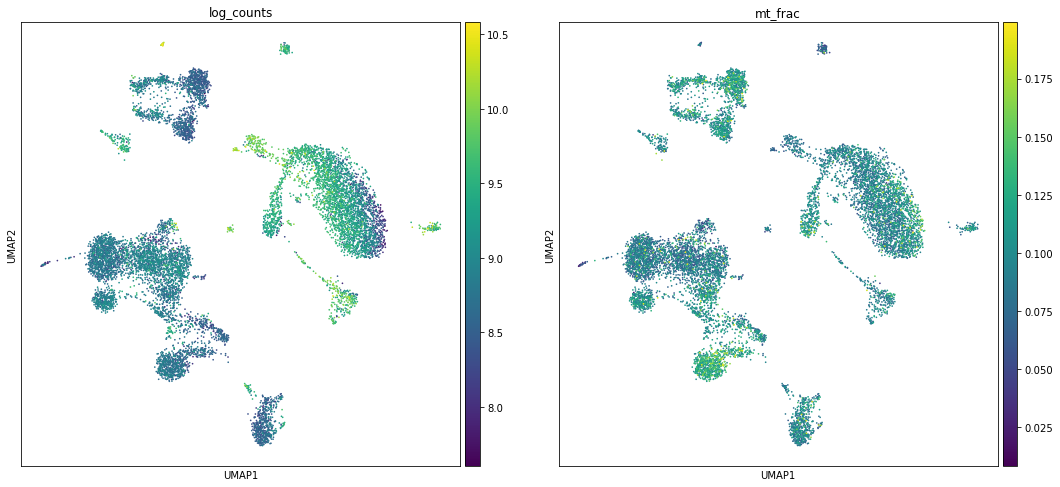

In [74]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 1)

In [75]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [76]:
markers_df = pd.read_csv('../../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [77]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [78]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [79]:
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [80]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [81]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [82]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

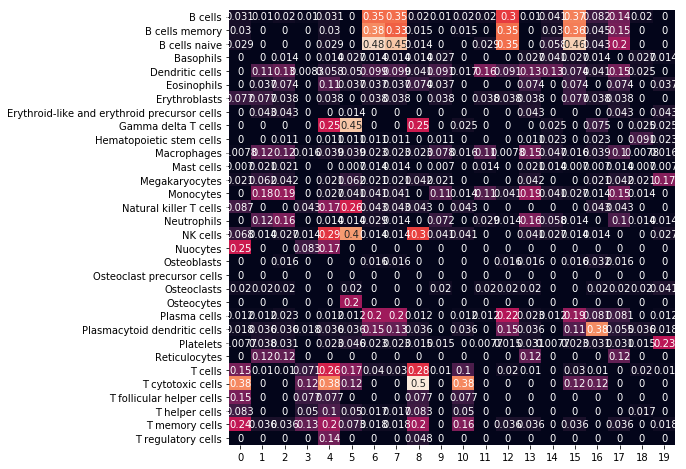

In [83]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

# 5. Plot makers of subtypes

In [84]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

We want to annotate CD8+ versus CD4+ cells.
For the labels to be consistent with the MCA-derived, we check the expression of those markers as well (when possible).

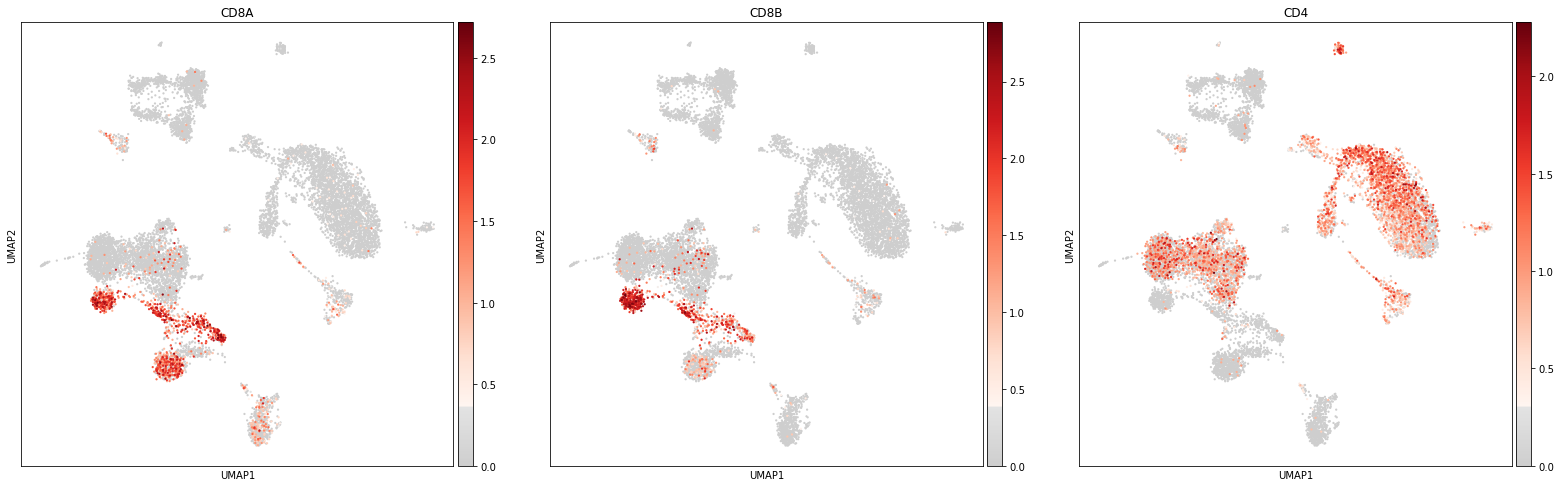

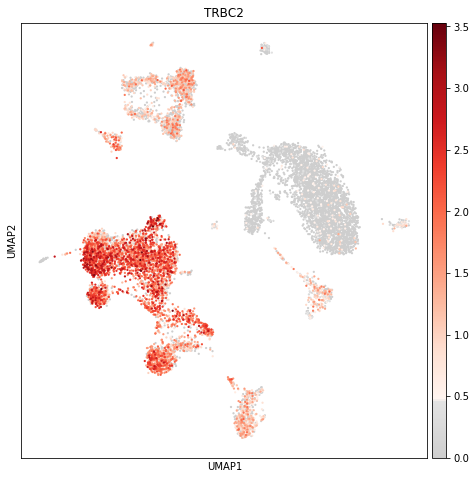

In [85]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 20)

# Markers from MCA
sc.pl.umap(adata, color=['TRBC2'], use_raw=False, color_map=mymap, size = 20)

### Natural killer T cells and NK cells
We consider NK cells as CD8- CD4-. NKT cells are instead CD8+/CD4+ and NKG7/GZMA +.

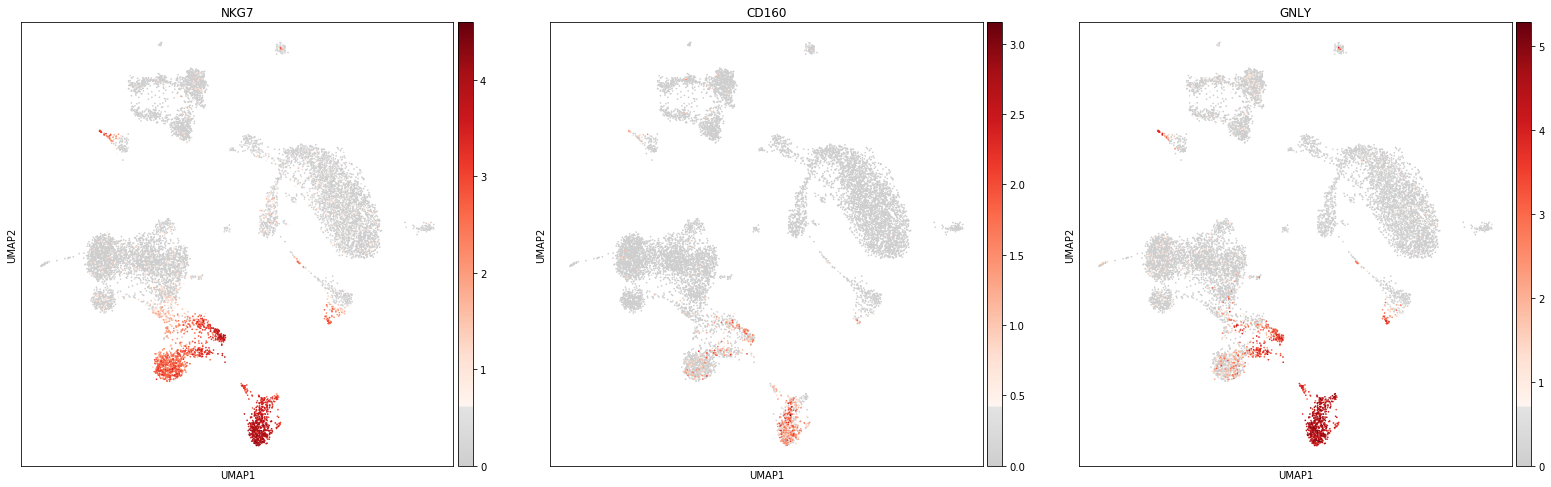

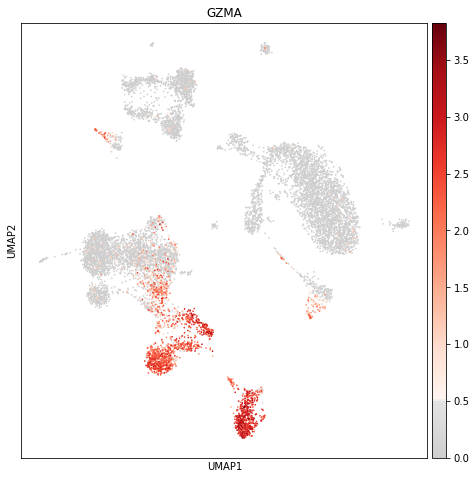

In [86]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap)

# marker from MCA
sc.pl.umap(adata, color=['GZMA'], use_raw=False, color_map=mymap)

A small part of cluster 4 is CD8-CD4- so NK (plus cluster 5). Cluster 8 and rest 4 are NKT.

## Monocytes: CD14+ and CD16+

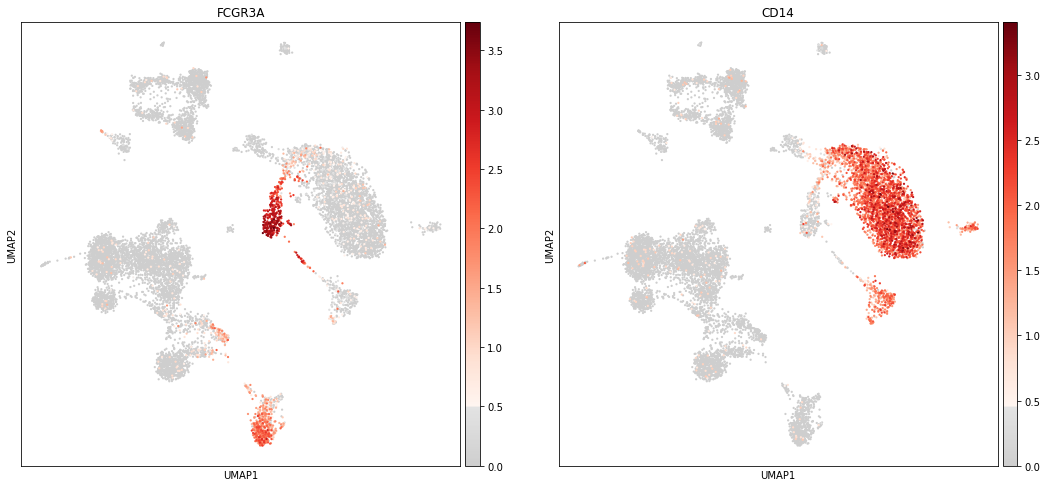

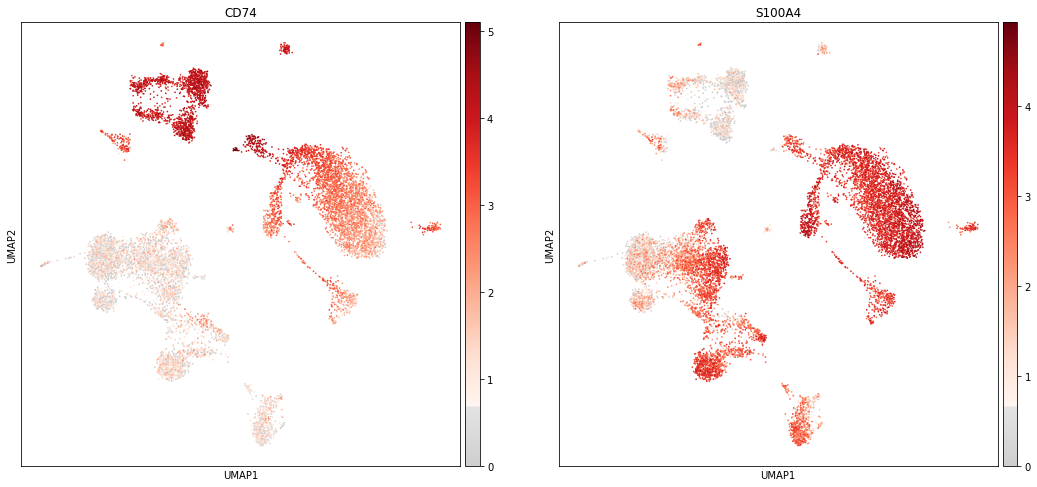

In [87]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap, size = 20)
# markers from MCA
sc.pl.umap(adata, color=['CD74', 'S100A4'], use_raw=False, color_map=mymap)

## Monocyte-derived Dendritic cells

Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

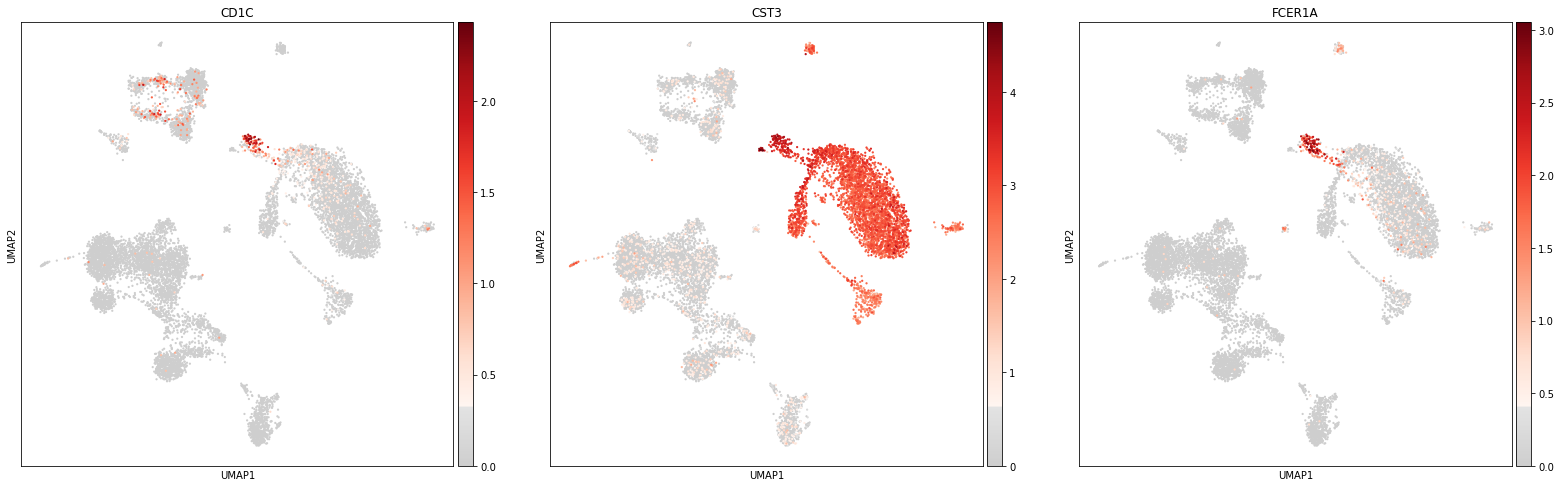

In [88]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap, size = 20)

Cluster 14

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

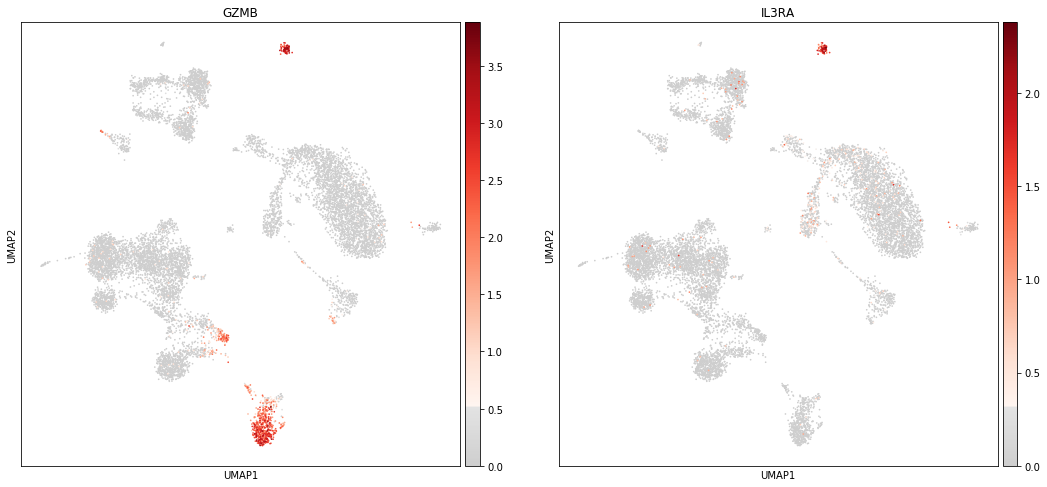

In [89]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

## B cells
Oetjen et al. annotates B cells as CD20+ (MS4A1) or CD10+ (MME).

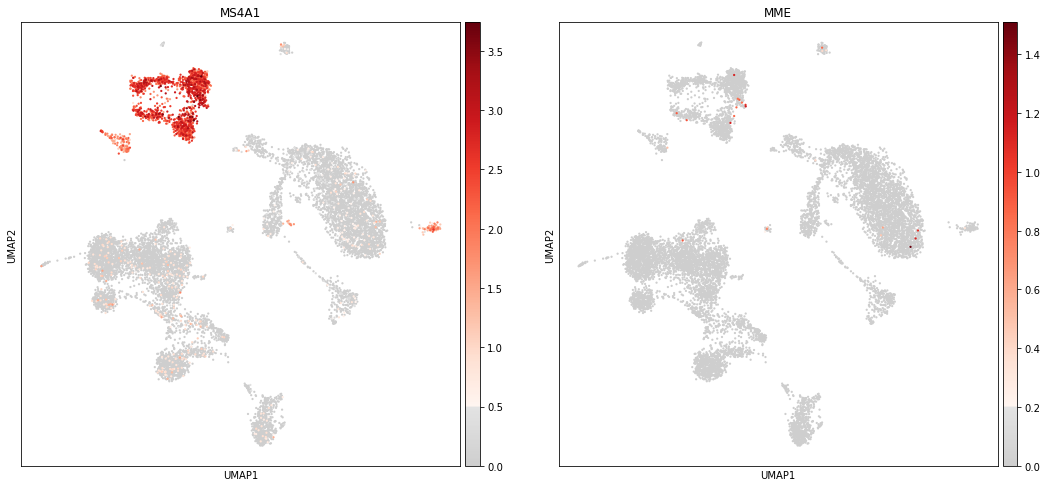

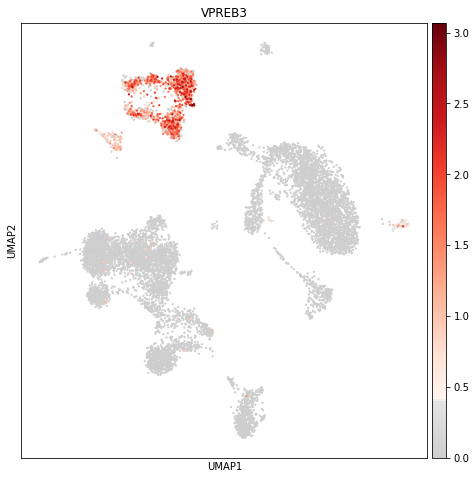

In [90]:
sc.pl.umap(adata, color=['MS4A1', 'MME'], use_raw=False, color_map=mymap, size = 20)

# markers from MCA
sc.pl.umap(adata, color=['VPREB3'], use_raw=False, color_map=mymap, size = 20)

## Megakaryocyte progenitors

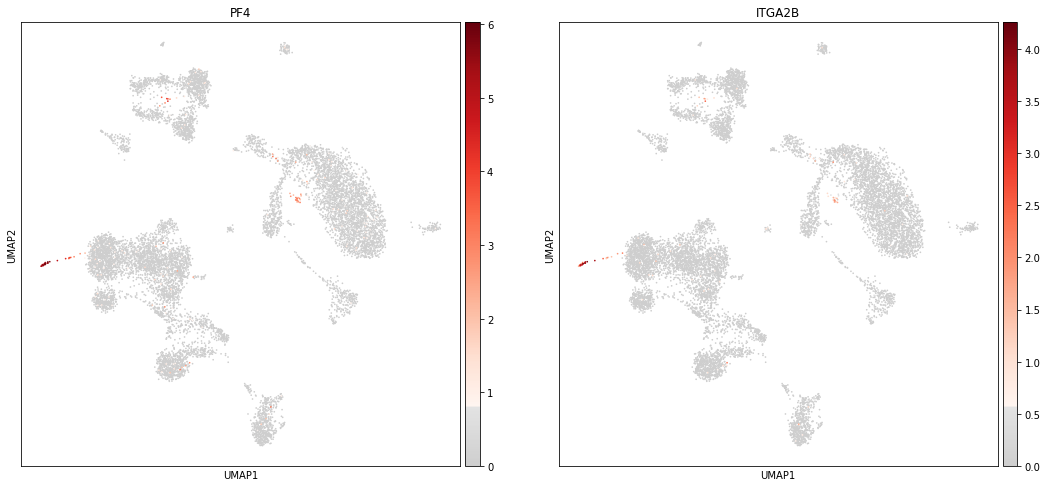

In [91]:
sc.pl.umap(adata, color=['PF4', 'ITGA2B'], use_raw=False, color_map=mymap)

## Plasma cells

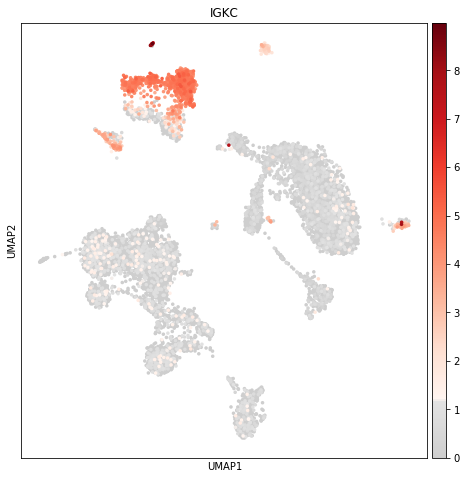

In [98]:
sc.pl.umap(adata, color=[ 'IGKC'], use_raw=False, color_map=mymap, size = 50)

## HSPCs

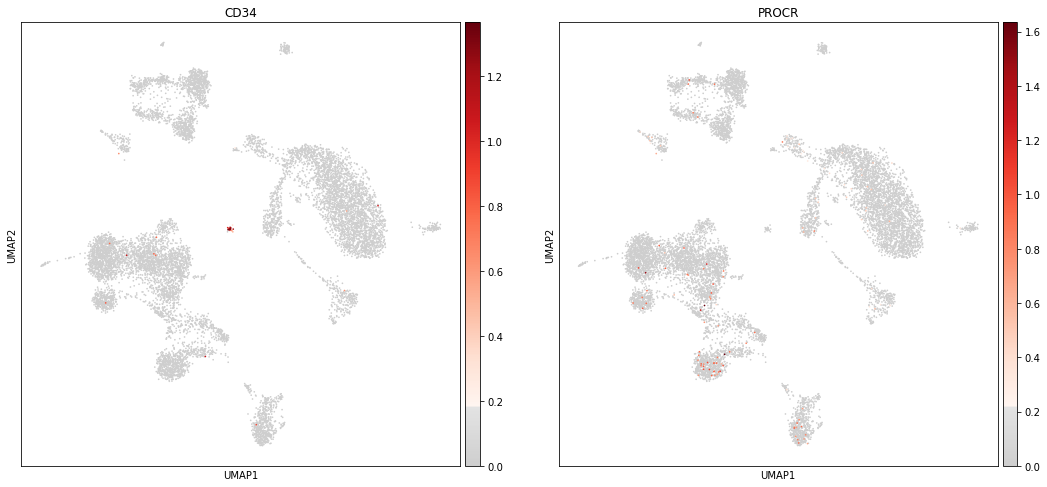

In [103]:
sc.pl.umap(adata, color=['CD34', 'PROCR'], use_raw=False, color_map=mymap)

# 6. Subclustering

We decide to subcluster cluster 4 (NKT+ NKcells) with the aim to better separate these cells

In [104]:
#Subcluster cluster4
sc.tl.louvain(adata, restrict_to=('louvain_r1', ['4']), resolution=0.2, key_added='louvain_r1_clust4_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_r1_clust4_sub', the cluster labels (adata.obs, categorical) (0:00:00)


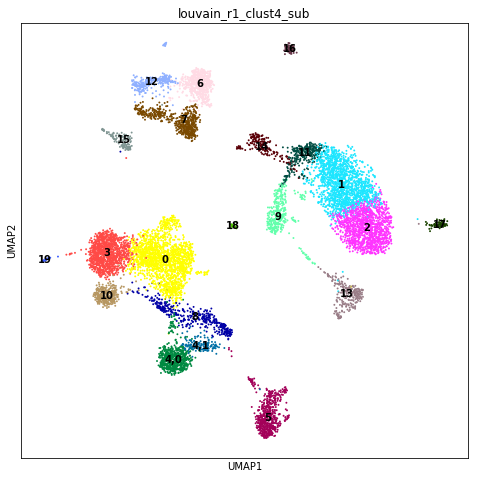

In [105]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_clust4_sub', size = 15, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [110]:
#Subcluster cluster12
sc.tl.louvain(adata, restrict_to=('louvain_r1_clust4_sub', ['12']), resolution=0.3, key_added='louvain_r1_clust4_sub_12')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain_r1_clust4_sub_12', the cluster labels (adata.obs, categorical) (0:00:00)


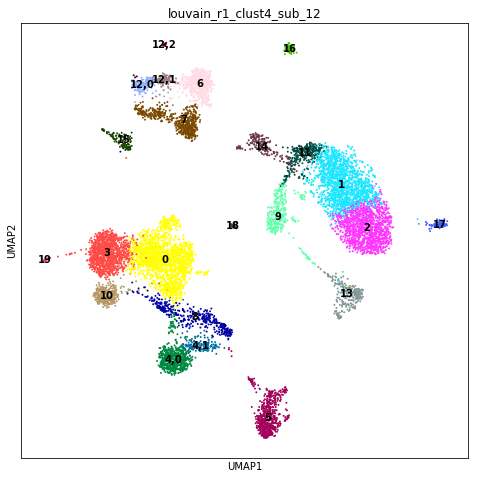

In [111]:
#Show the new clustering
sc.pl.umap(adata, color='louvain_r1_clust4_sub_12', size = 15, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

# 7. Final cell-type annotation

In [5]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1_clust4_sub_12']
adata.rename_categories('final_annotation', ['CD4+ T cells, 1',
                                             'CD14+ Monocytes, 1',
                                             'CD14+ Monocytes, 2',
                                             'CD4+ T cells, 2', 
                                             'NKT cells, 1',
                                             'NK cells,1',
                                             'NK cells,2',
                                             'CD20+ B cells, 1',
                                             'CD20+ B cells, 2',
                                             'NKT cells,2',
                                             'CD16+ Monocytes',
                                             'CD8+ T cells',
                                             'CD14+ Monocytes,3',
                                             'CD20+ B cells, 3', 
                                             'CD20+ B cells, 4',
                                             'Plasma cells',
                                             'CD14+ Monocytes,4',
                                             'Monocyte-derived dendritic cells',
                                             'CD20+ B cells, 5',
                                             'Plasmacytoid dendritic cells' ,
                                             'CD14+ Monocytes, 5',
                                             'HSPCs',
                                             'Megakaryocyte progenitors'])

In [6]:
tmp = adata.obs['final_annotation']
tmp = ['CD20+ B cells' if item.startswith('CD20+ B cells') else item for item in tmp]
tmp = ['CD4+ T cells' if item.startswith('CD4+ T ') else item for item in tmp]
tmp = ['CD14+ Monocytes' if item.startswith('CD14+ Monocytes') else item for item in tmp]
tmp = ['NK cells' if item.startswith('NK cells') else item for item in tmp]
tmp = ['NKT cells' if item.startswith('NKT cells') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


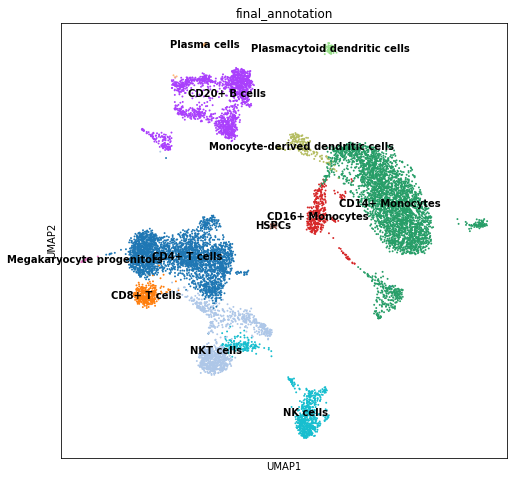

In [7]:
sc.pl.umap(adata, color='final_annotation', size=15, legend_loc='on data')

In [8]:
# save final result
adata.write(results_file)